# Import Model

In [1]:
from python_scripts.pretrain_model import PretrainedEncoderRegressor
import torch.nn as nn

name = 'AE_Center_noaug'

checkpoint_path = f"AE_model/{name}/best.pt"

# 1) 实例化（会自动加载并冻结 encoder）
model = PretrainedEncoderRegressor(
    ae_checkpoint=checkpoint_path,
    ae_type="center",
    center_dim=64, neighbor_dim=64, hidden_dim=128,
    tile_size=26, output_dim=35,
    freeze_encoder = True
)

# 2) monkey‐patch 一个新的 head
model.decoder  = nn.Sequential(
    nn.Linear(64+64, 256),
    nn.SiLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.SiLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 64),
    nn.SiLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 35)
    
)

# 3) 再次检查只训练 head
# for name, p in model.named_parameters():
#     print(name, p.requires_grad)



# —— 5) 确保只有 decoder 可训练 ——  
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")


Trainable / total params = 76,451 / 1,130,787


/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/pretrain_model.py:228: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load(ae_checkpoint, map_

## Load Model

# Import training data

## Same in multiple .pt

In [2]:
import os
import torch

import inspect
from python_scripts.import_data import load_all_tile_data
import numpy as np

# 用法範例
#folder = "dataset/spot-rank/version-3/only_tile_sub/original_train"
folder = "dataset/spot-rank/filtered_directly_rank/masked/realign/Macenko_masked/filtered/train_data/"

grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/import_data.py:285: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

Loaded keys: dict_keys(['label', 'subtiles', 'source_idx', 'tile', 'slide_idx'])
Samples: 8348


In [3]:
import os
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from python_scripts.operate_model import train_one_epoch, evaluate, predict, plot_losses, plot_per_cell_metrics,spear_EarlyStopping
import torch.nn as nn

# ---------------------------
# 指定儲存資料夾
# ---------------------------
save_folder = f"/Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/{name}/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked"  # 修改為你想要的資料夾名稱
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


In [4]:
# --------------------------------------------
# 2) 從 grouped_data 取出 slide_idx，轉成 numpy
# --------------------------------------------
import numpy as np
slide_idx = np.array(grouped_data['slide_idx'])   # shape (N,)

# --------------------------------------------
# 3) 建立 LOGO（或改成 GroupKFold）
# --------------------------------------------
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

# X 可以給虛擬矩陣，因為分組只靠 groups
X_dummy = np.zeros(len(slide_idx))
X_dummy

array([0., 0., 0., ..., 0., 0., 0.])

✅ Saved best model in /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/fold2/best_model.pt!
[Epoch 14]  lr=2.77e-04, train_loss=44.6458, val_loss=42.4681
train spearman: 0.7511 | Val spearman: 0.7545 | best: 0.7545


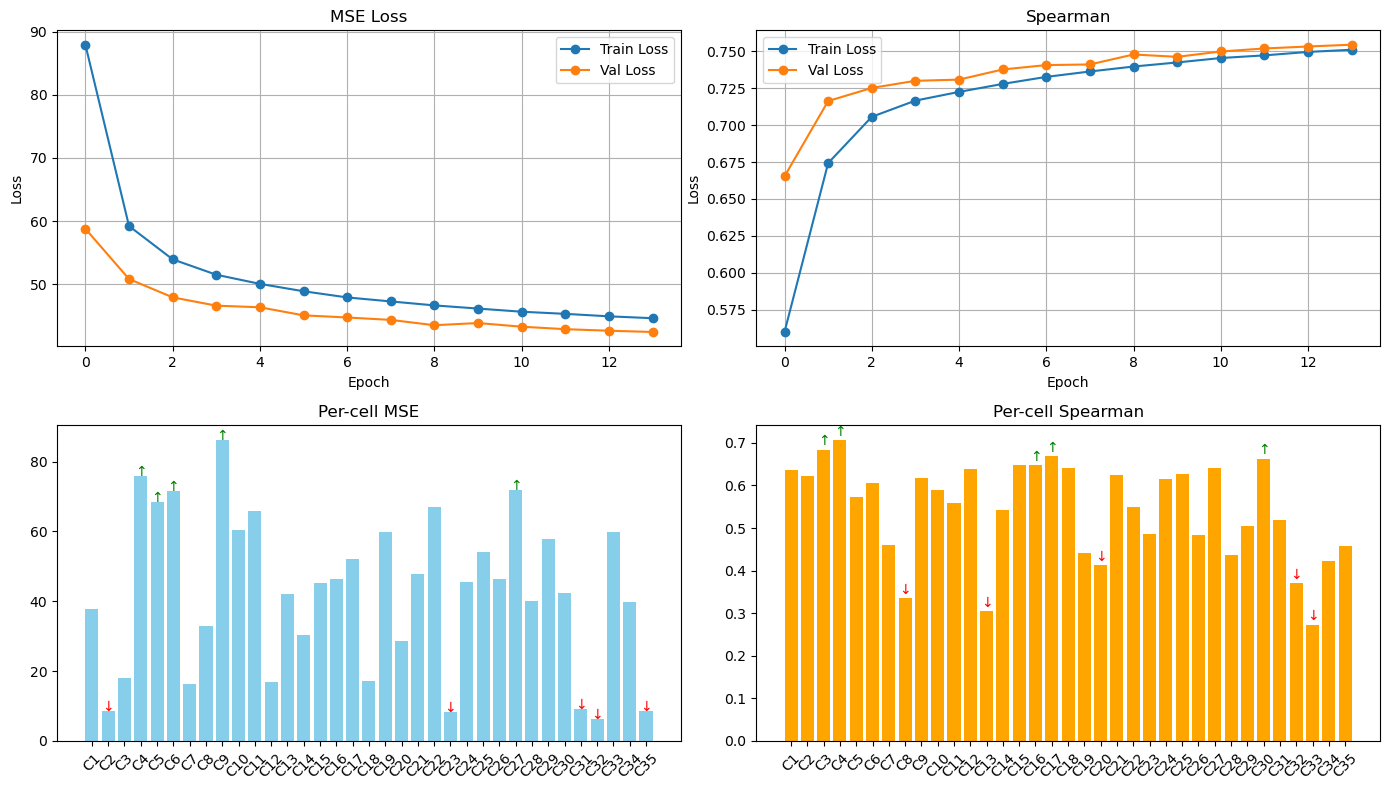

<Figure size 640x480 with 0 Axes>

曲線圖已儲存至 /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/fold2/loss_curve.png


Training:  23%|██▎       | 143/627 [00:15<00:57,  8.48it/s, avg=44.4, loss=45.6]

In [ ]:
from torch.utils.data import DataLoader
from python_scripts.import_data import importDataset
from python_scripts.aug         import augment_grouped_data, identity, subset_grouped_data
import math
from torch.optim.lr_scheduler import LambdaLR
# ---------------- 基本參數 ----------------
start_fold = 2   # 从第几个 fold 开始训练（0-based），小于此值的 fold 会跳过

BATCH_SIZE   = 64
num_epochs   = 200
repeats      = 5
# ---------------- 參數設定 ----------------
save_root    = save_folder          # 最外層
os.makedirs(save_root, exist_ok=True)

# Seed once at the very top for reproducibility

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("✅ device:", device)

overall_best = []
# 在你的脚本文件头部



# 假设 grouped_data['slide_idx'] 是长度为 N 的列表
indices = np.arange(len(grouped_data['slide_idx']))
for fold_id, (tr_idx, va_idx) in enumerate(kf.split(indices)):


    
        # 如果当前 fold < start_fold，就跳过
    if fold_id < start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue
    
    print("Starting fold", fold_id)
    print("Starting subseting...")

    train_base = subset_grouped_data(grouped_data, tr_idx)
    print("Starting augmenting...")

    train_ds = augment_grouped_data(
                    grouped_data=train_base,
                    image_keys=['tile','subtiles'],
                    repeats=repeats   # 比如对每张做 2 次增强
                )
    print("Starting importDataset...")
    # 1) 原始 dataset
    train_ds = importDataset(train_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)


    # 3) validation raw
    val_ds     = subset_grouped_data(grouped_data, va_idx)
    val_ds     = importDataset(val_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)

    print("Starting DataLoader...")
    # 4) DataLoader 不再動態增強
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=False)

    # 5) 一切其餘步驟同之前：定模型、optimizer、train_one_epoch、evaluate……

    print("Starting model...")
    # ----- 新建模型 / 優化器 -----
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="center",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)

    # 我们把原来 Adam 换成 AdamW，稍微加一点 weight decay
    peak_lr       = 5e-4
    min_lr        = 1e-6
    warmup_epochs = 0
    total_epochs  = 30

    unfreeze_epoch = 0  # 比如在第 50 个 epoch 解冻 encoder
    encoder_lr     = 1e-5

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=peak_lr, weight_decay=1e-3
    )

    # 定义 lr_lambda
    def lr_lambda(cur_epoch):
        if cur_epoch < warmup_epochs:
            # 线性 warm-up: 从 0 → 1
            return float(cur_epoch + 1) / warmup_epochs
        else:
            # 余弦退火：从 1 → min_lr/peak_lr
            progress = (cur_epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            # cos(0)=1 → cos(pi)=−1, remap to [min_ratio,1]
            min_ratio = min_lr / peak_lr
            return min_ratio + 0.5 * (1 - min_ratio) * (1 + math.cos(math.pi * progress))

    scheduler = LambdaLR(optimizer, lr_lambda)

    stopper = spear_EarlyStopping(patience=15)

    # ----- fold 專屬輸出路徑 -----
    fold_dir  = os.path.join(save_folder, f"fold{fold_id}")
    os.makedirs(fold_dir, exist_ok=True)
    best_model_path = os.path.join(fold_dir, "best_model.pt")
    loss_plot_path  = os.path.join(fold_dir, "loss_curve.png")
    csv_path        = os.path.join(fold_dir, "training_log.csv")

    # ----- CSV log -----
    log_f = open(csv_path, "w", newline="")
    csv_w = csv.writer(log_f)
    csv_w.writerow(["Epoch","TrainLoss","ValLoss","ValSpearman","LR"])

    # ----- 圖形 -----
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    display(fig)

    train_losses = []; val_losses = []
    train_rhos   = []; val_rhos   = []

    best_rho = -1.0
    print("Starting training...")
    for epoch in range(num_epochs):
        if epoch == unfreeze_epoch:
            print(f"*** Unfreezing encoder at epoch {epoch} and adding to optimizer ***")
        # 把 encoder 的参数解冻并加入 optimizer
            net.unfreeze_encoder(lr=encoder_lr, optimizer=optimizer)

        tloss, trho = train_one_epoch(
            net, train_loader, optimizer, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20 )

        vloss, vrho, mse_cell, rho_cell = evaluate(
            net, val_loader, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20 )

        clear_output(wait=True)  # 清除之前的輸出
        axes[0][0].clear()
        axes[0][1].clear()
        axes[1][0].clear()
        axes[1][1].clear()
        # --- save best ---
        if vrho > best_rho:
            best_rho = vrho
            torch.save(net.state_dict(), best_model_path)
            print(f"✅ Saved best model in {best_model_path}!")

        # --- scheduler / early stop ---
        scheduler.step()
        stopper(vrho)


    
        # --- logging ---
        lr = optimizer.param_groups[0]['lr']
        csv_w.writerow([epoch+1, tloss, vloss, vrho, lr])

        train_losses.append(tloss); val_losses.append(vloss)
        train_rhos.append(trho);   val_rhos.append(vrho)
        

        

        # 印出 Epoch 結果
        lr = optimizer.param_groups[0]['lr']
        print(f"[Epoch {epoch+1}]  lr={lr:.2e}, train_loss={tloss:.4f}, val_loss={vloss:.4f}")
        print(f"train spearman: {trho:.4f} | Val spearman: {vrho:.4f} | best: {best_rho:.4f}")
        # --- update plots ---
        plot_losses(train_losses, val_losses, axes[0][0], "MSE Loss")
        plot_losses(train_rhos,   val_rhos,   axes[0][1], "Spearman")
        cell_names = [f"C{i+1}" for i in range(35)]
        plot_per_cell_metrics(mse_cell, rho_cell, cell_names,
                              ax_mse=axes[1][0], ax_spearman=axes[1][1])
        plt.tight_layout(); display(fig); plt.pause(0.1)
        fig.savefig(loss_plot_path)
        print(f"曲線圖已儲存至 {loss_plot_path}")
        if stopper.early_stop:
            print("⛔ early stop"); break

    log_f.close(); plt.close(fig)
    overall_best.append(best_rho) 
    print(f"📈 Fold {fold_id} best ρ = {best_rho:.4f}")

# ========= 整體結果 =========
overall_best = np.array(overall_best)
print("\n=========== CV summary ===========")
for i, r in enumerate(overall_best):
    print(f"fold {i}: best ρ = {r:.4f}")
print(f"overall best (mean) ρ = {overall_best.mean():.4f} ± {overall_best.std():.4f}")

In [2]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict

full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)
# ---------------- Settings ----------------
save_root  = save_folder  # your save_folder path
n_folds    = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35  # num cell types
start_fold = 0
BATCH_SIZE = 64
# If optimizing Spearman, convert labels to ranks
use_rank   = False

# --- 1) Prepare OOF meta-features ---
# Initialize matrix for OOF predictions
n_samples = len(full_dataset)
oof_preds = np.zeros((n_samples, C), dtype=np.float32)
# True labels (raw or rank)
# importDataset returns a dict-like sample, so label is under key 'label'
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
if use_rank:
    y_meta = np.apply_along_axis(rankdata, 1, y_true)
else:
    y_meta = y_true

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()

# Loop over folds, load best model, predict on validation indices
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):
    # Load model
    if fold_id > start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    print(f"Loading model from {ckpt_path}...")
    net = model.to(device)
    # Alternatively, if your model requires specific args, replace with:
    # net = VisionMLP_MultiTask(tile_dim=64, subtile_dim=64, output_dim=35).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()

    # Predict on validation set
    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, val_loader, device)  # (n_val, C)
    oof_preds[va_idx] = preds
    print(f"Fold {fold_id}: OOF preds shape {preds.shape}")

# --- 2) Train LightGBM meta-model ---
# Choose objective: regression on rank (for Spearman) or raw (for MSE)
lgb_base = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.001,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    force_col_wise=True
)

meta_model = MultiOutputRegressor(lgb_base)
print("Training LightGBM on OOF meta-features...")
meta_model.fit(oof_preds, y_meta)
# Save meta-model
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))

# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)
for fold_id in range(n_folds):
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = model.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, test_loader, device)
    test_meta += preds
# Average across folds
test_meta /= n_folds

# --- 4) Meta-model predict ---
if use_rank:
    final_preds = meta_model.predict(test_meta) / (C + 1)
else:
    final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'grouped_data' is not defined

In [11]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict

# --- 配置: 只用哪些 fold 的结果来训练/预测 meta-model ---
meta_folds = [0,1,2,3,4,5]  # 例如只用 fold0, fold2, fold4

# 1) 准备 full_dataset, slide_idx, test_dataset 等
full_dataset = importDataset(
    grouped_data, model,
    image_keys=['tile','subtiles'],
    transform=lambda x: x
)
n_samples = len(full_dataset)
C = 35  # 类别数

# 2) 预留 oof_preds 和 fold_ids
oof_preds    = np.zeros((n_samples, C), dtype=np.float32)
oof_fold_ids = np.full(n_samples, -1, dtype=int)

# 真标签
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
y_meta = y_true.copy()  # 不做 rank 时直接用 raw

# 3) 生成 OOF 预测并记录 fold id
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):

    # 如果当前 fold 不在我们想要的 meta_folds 列表里，就跳过
    if fold_id not in meta_folds:
        print(f"⏭️ Skipping OOF for fold {fold_id}")
        continue

    print(f"\n>>> Generating OOF for fold {fold_id}")
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    val_loader = DataLoader(Subset(full_dataset, va_idx), batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, val_loader, device)  # (n_val, C)

    oof_preds[va_idx]    = preds
    oof_fold_ids[va_idx] = fold_id

    print(f"  → Fold {fold_id} OOF preds shape: {preds.shape}")
# 4) 只选取 meta_folds 的行来训练 meta-model
mask = np.isin(oof_fold_ids, meta_folds)
X_meta = oof_preds[mask]
y_meta_sub = y_meta[mask]

print(f"\nTraining meta-model on folds {meta_folds}:")
print(f"  使用样本数：{X_meta.shape[0]} / {n_samples}")

lgb_base = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.001,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    force_col_wise=True
)
meta_model = MultiOutputRegressor(lgb_base)
meta_model.fit(X_meta, y_meta_sub)
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))

# 5) 准备 test_meta，只平均 meta_folds 中的预测
n_folds = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_test  = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)

for fold_id in range(n_folds):
    if fold_id not in meta_folds:
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)
    test_meta += preds

# 平均时除以参与的 folds 数目
test_meta /= len(meta_folds)

# 6) 用 meta-model 做最终预测
final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd

with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))

sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")



>>> Generating OOF for fold 0
  → Fold 0 OOF preds shape: (2197, 35)

>>> Generating OOF for fold 1
  → Fold 1 OOF preds shape: (2269, 35)

>>> Generating OOF for fold 2
  → Fold 2 OOF preds shape: (690, 35)

>>> Generating OOF for fold 3
  → Fold 3 OOF preds shape: (1187, 35)

>>> Generating OOF for fold 4
  → Fold 4 OOF preds shape: (1677, 35)

>>> Generating OOF for fold 5
  → Fold 5 OOF preds shape: (328, 35)

Training meta-model on folds [0, 1, 2, 3, 4, 5]:
  使用样本数：8348 / 8348
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start training from score 26.067920
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start training from score 27.408960
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start tr

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

✅ Saved stacked submission.


In [12]:
import os
import numpy as np
import joblib
from scipy.stats import rankdata
import lightgbm as lgb
from sklearn.model_selection import LeaveOneGroupOut
from torch.utils.data import DataLoader, Subset
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict


# --- 配置 ---
meta_folds = [0,1,2,3,4,5]  # 例如只用 fold0, fold2, fold4
C          = 35       # cell type 数量
BATCH_SIZE = 64

# 1) 导入 full_dataset, slide_idx, test_dataset
full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)
n_spots = len(full_dataset)

# 2) 生成 OOF preds & 记录 fold id (同你之前做法)
oof_preds    = np.zeros((n_spots, C), dtype=np.float32)
oof_fold_ids = np.full(n_spots, -1, dtype=int)
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_spots), y=None, groups=slide_idx)):
    if fold_id not in meta_folds:
        continue
    # load CNN model & predict
    ckpt = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net  = model.to(device)
    net.load_state_dict(torch.load(ckpt, map_location=device))
    net.eval()
    loader = DataLoader(Subset(full_dataset, va_idx),
                        batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)  # (n_val, C)
    oof_preds[va_idx]    = preds
    oof_fold_ids[va_idx] = fold_id

# 真标签矩阵 (n_spots, C)
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy()
                     for i in range(n_spots) ])

# 3) 筛出 meta_folds 的行
mask       = np.isin(oof_fold_ids, meta_folds)
X_meta     = oof_preds[mask]    # (N_meta, C)
y_meta     = y_true[mask]       # (N_meta, C)
slides_sub = slide_idx[mask]    # (N_meta,)

N_meta = X_meta.shape[0]

docs_feat = X_meta.reshape(-1, 1)   # 变成 (N_meta * 35, 1)

# 对应的真实 abundance，也要 flatten
docs_true = y_meta.reshape(-1,)     # (N_meta * 35,)

# 每个 spot 里对 35 个 abundance 做 ordinal 排，即 relevance label
docs_rel = np.zeros_like(docs_true, dtype=int)
for i in range(X_meta.shape[0]):
    start = i * C
    end   = start + C
    docs_rel[start:end] = rankdata(
        docs_true[start:end],
        method='ordinal'
    ) - 1          # 变成 0‐based

# Flatten 之后的 group：每个 spot 下固定 35 条 doc
train_group = [C] * X_meta.shape[0]  # e.g. [35,35,35, ...] 长度 = N_meta

# ------------------------ 2) 训练一个 LGBMRanker ------------------------
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    metric='ndcg@35',      # 也可以只关注 ndcg@5、@10
    label_gain=list(range(docs_rel.max()+1)),
    learning_rate=1e-3,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1
)
ranker.fit(
    docs_feat,   # (N_meta*35, 1)
    docs_rel,    # (N_meta*35,)
    group=train_group
)

# ------------------------ 3) 测试时同样 Flatten + Predict ------------------------
# 5) 准备 test_meta，只平均 meta_folds 中的预测
n_folds = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_test  = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)

for fold_id in range(n_folds):
    if fold_id not in meta_folds:
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = model.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)
    test_meta += preds

# 平均时除以参与的 folds 数目
test_meta /= len(meta_folds)

docs_test_feat = test_meta.reshape(-1, 1)     # (n_test*35, 1)
test_group     = [C] * test_meta.shape[0]    # [35, 35, ..., 35]

docs_test_score = ranker.predict(docs_test_feat, group=test_group)  # (n_test*35,)

# 把分数 reshape 回 (n_test, 35)
scores = docs_test_score.reshape(test_meta.shape[0], C)  


final_scores = test_meta*scores
# 6) 写入 submission
import pandas as pd, h5py


with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))

sub = pd.DataFrame(final_scores, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_LGBMRanker.csv'), index=False)
print("✅ Saved stacked submission.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 292180, number of used features: 1


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


✅ Saved stacked submission.


# Predict

In [7]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs

def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    根据 model.forward 的参数自动加载 .pt 里对应的字段，
    并且如果没有 label，就自动创建一个全 0 的 label 张量，
    其尺寸为 (样本数, num_cells)，样本数从第一个有 __len__ 的输入推断。

    参数：
      pt_path:     str，.pt 文件路径
      model:       已实例化的 PyTorch 模型
      num_cells:   int，label 的列数（默认 35）

    返回：
      dict: key 对应模型 forward 中的参数名（不含 self），
            value 是对应的 Tensor/ndarray，
            并额外保证有 'label' 字段。
    """
    # 1) 载入原始数据
    raw = torch.load(pt_path, map_location="cpu")

    # 2) 取模型 forward 入参签名（不含 self）
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) 直接同名
        if name in raw:
            out[name] = raw[name]
            continue
        # b) 复数形式
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) 模糊匹配（下划线、复数或前后缀）
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"无法找到 '{name}' 在 pt 文件中的对应字段，raw keys: {list(raw.keys())}")

    # 3) 用第一个支持 len() 的输入推断样本数
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"⚠️ 从 '{v}' 推断样本数量: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("无法从任何输入中推断样本数量，请检查 pt 文件内容。")

    # 4) 自动补 label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
    return out


image_keys = [ 'tile', 'subtiles']


# 用法示例
from python_scripts.import_data import importDataset
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/Macenko/test_dataset.pt", model)
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )



/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_1022/2163754159.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu")

⚠️ 从 'tile' 推断样本数量: 2088
Model forward signature: (tile, subtiles)


In [ ]:

test_dataset.check_item(1000, 10)


In [8]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
import glob
import torch
import numpy as np
import pandas as pd
import os
import h5py
from torch.utils.data import DataLoader

# 讀 test spot index
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spots     = f["spots/Test"]
    test_spot_table= pd.DataFrame(np.array(test_spots['S_7']))

fold_ckpts = sorted(glob.glob(os.path.join(save_folder, "fold*", "best_model.pt")))
models = []
for ckpt in fold_ckpts:
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="center",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = False
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt, map_location="cpu"))
    net.to(device).eval()
    models.append(net)

all_fold_preds = []
for fold_id, net in enumerate(models):
    # 推論
    with torch.no_grad():
        preds = predict(net, test_loader, device)  # (N_test,35) numpy array

    # 1) 存每一折的原始預測
    df_fold = pd.DataFrame(preds, columns=[f"C{i+1}" for i in range(preds.shape[1])])
    df_fold.insert(0, "ID", test_spot_table.index)
    path_fold = os.path.join(save_folder, f"submission_fold{fold_id}.csv")
    df_fold.to_csv(path_fold, index=False)
    print(f"✅ Saved fold {fold_id} predictions to {path_fold}")

    all_fold_preds.append(preds)

# 2) 做 rank‐average ensemble
all_fold_preds = np.stack(all_fold_preds, axis=0)       # (K, N_test, 35)
ranks          = all_fold_preds.argsort(axis=2).argsort(axis=2).astype(float)
mean_rank      = ranks.mean(axis=0)                    # (N_test,35)

# 3) 存 final ensemble
df_ens = pd.DataFrame(mean_rank, columns=[f"C{i+1}" for i in range(mean_rank.shape[1])])
df_ens.insert(0, "ID", test_spot_table.index)
path_ens = os.path.join(save_folder, "submission_rank_ensemble.csv")
df_ens.to_csv(path_ens, index=False)
print(f"✅ Saved rank‐ensemble submission to {path_ens}")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_1022/3783984943.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt, map_loca

✅ Saved fold 0 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/submission_fold0.csv
✅ Saved fold 1 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/submission_fold1.csv
✅ Saved rank‐ensemble submission to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/submission_rank_ensemble.csv
